# Validación en entorno industrial

````{admonition} Resumen 
:class: tip

Este informe presenta la validación en entorno productivo real del sistema FLATCLASS, el prototipo automático de clasificación de alevines de lenguado (*Solea senegalensis*) basado en visión artificial. La validación se realizó en las instalaciones de Satistela S.A. ([Grupo Sea8](https://https://seaeight.eu/contacto/)) en Póvoa de Varzim (Portugal), mediante un protocolo multi-experimento diseñado para cuantificar: 1) la precisión en la clasificación por intervalos de talla (pequeño, mediano y grande), y 2) la exactitud en la estimación individual de biomasa de cada individuo detectado. El estudio se apoya en 1.250 observaciones (5 experimentos, 250 peces) y evalúa: exactitud, precisión, estabilidad inter-experimento, acuerdo metrológico (Bland–Altman), heterocedasticidad y un análisis Monte Carlo del riesgo de error de clasificación inducido por la incertidumbre dimensional.

**Entregable**: E6.1  
**Versión**: 1.0  
**Autor**: Javier Álvarez Osuna  
**Email**: javier.osuna@fishfarmfeeder.com  
**ORCID**: [0000-0001-7063-1279](https://orcid.org/0000-0001-7063-1279)  
**Licencia**: CC-BY-4.0  
**Código proyecto**: IG408M.2025.000.000072

```{figure} .././assets/FLATCLASS_logo_publicidad.png
:width: 100%
:align: center
```
````

## Objetivo

El **objetivo general** planteado en la validación industrial de FLATCLASS reside en comprobar hasta qué punto el sistema de visión artificial desarrollado en el {doc}`PT-1 <content/01/Modulo-3>` es capaz de clasificar de forma fiable los juveniles de lenguado en las tres diferentes tallas (pequeño, normal, grande), teniendo en cuenta la incertidumbre inherente a las mediciones realizadas en condiciones reales de operación.

Para ello, se han planteado los siguientes **objetivos específicos** orientados a analizar, de manera estructurada y cuantitativa, los distintos factores que condicionan la fiabilidad del proceso de clasificación. Estos objetivos permiten descomponer el problema global en aspectos medibles relacionados con la calidad metrológica de las estimaciones dimensionales, su estabilidad temporal, el grado de acuerdo con las medidas de referencia y el impacto práctico de los errores de medición sobre la decisión final de asignación de talla.

 1. Caracterizar estadísticamente la exactitud y precisión de las mediciones dimensionales (longitud y anchura) obtenidas mediante el sistema de visión artificial, comparándolas con las medidas de referencia realizadas en laboratorio, con el fin de cuantificar el error medio, la dispersión y la presencia de posibles sesgos sistemáticos.
 2.	Evaluar el grado de acuerdo metrológico entre las medidas estimadas y las reales, utilizando análisis de Bland–Altman y métricas complementarias, para interpretar la incertidumbre del sistema directamente en unidades físicas relevantes para la clasificación por talla.
 3.	Analizar la estabilidad temporal del sistema de medición y clasificación, comparando el comportamiento estadístico de los errores a lo largo de varios experimentos consecutivos realizados en días distintos, con el objetivo de detectar posibles derivas o variaciones operativas.
 4.	Examinar la relación entre el tamaño del individuo y la magnitud del error de medida, identificando posibles efectos de heterocedasticidad y dependencias con la talla que puedan influir en la fiabilidad de la clasificación en distintos rangos de tamaño.
 5.	Evaluar el desempeño del peso inferido como variable secundaria, analizando su precisión y variabilidad, y determinar su idoneidad para la estimación de biomasa agregada por clase de talla, en lugar de su uso como criterio primario de clasificación individual.
 6.	Cuantificar el impacto práctico de la incertidumbre dimensional sobre la decisión de clasificación por talla, mediante simulaciones Monte Carlo que permitan estimar la probabilidad de cambio de clase inducida por los errores de medición.
 7.	Identificar los rangos de talla más sensibles a la inestabilidad de clasificación, especialmente en torno a los umbrales entre clases, con el fin de caracterizar las zonas de mayor riesgo de asignación incorrecta.
 8.	Proponer criterios estadísticos para el diseño y validación de los umbrales de clasificación por talla, basados en percentiles del error dimensional, que permitan reducir el riesgo de inestabilidad de clasificación en aplicaciones operativas.
 9.	Proporcionar una base metodológica reproducible para la validación de sistemas de clasificación por visión artificial, integrando análisis metrológico, estadístico y de toma de decisiones, aplicable a otros contextos industriales y especies acuícolas.

## Metodología

### Diseño experimental

El dataset contiene **1.250 registros** correspondientes a **cinco experimentos realizados en días consecutivos** (`exp = 1..5`), con **250 juveniles por experimento**. Cada individuo se mide en cinta mediante un sistema 
de visión artificial que entrega dimensiones de **longitud** y **anchura** en píxeles que mediante conversión calibrada se registran en milímetros (`L_av`, `A_av`). A partir de estas dimensiones se produce la inferencia de peso en tiempo real (`peso_pred`)mediante el modelo alométrico previamente validado (PT-3). Como referencia, se registra **longitud real** (`L_real`), **anchura real** (`A_real`) mediante tallado manual en medición única y **peso real** (`peso_g`) mediante báscula.

Las condiciones experimentales (cámara, iluminación, calibración geométrica, procedimiento) fueron idénticas en los cinco días, permitiendo evaluar la estabilidad temporal del sistema.

```{admonition} Objetivo del sistema
:class: important
El objetivo operativo principal es la **clasificación por talla** en tres categorías discretas (pequeño, mediano, grande) basada principalmente en las **dimensiones**.  
El peso inferido se considera objetivo secundario para **biomasa agregada por clase**.
```

### Variables disponibles en el dataset

El análisis utiliza **exclusivamente** las siguientes columnas, sin generar variables adicionales no documentadas:

| Variable | Columna |
|--------|--------|
| Experimento / día | `exp` |
| Peso real (g) | `peso_g` |
| Longitud real (mm) | `L_real` |
| Anchura real (mm) | `A_real` |
| Longitud en píxeles | `Longitud_px` |
| Anchura en píxeles | `Anchura_px` |
| Longitud estimada por visión (mm) | `L_av` |
| Anchura estimada por visión (mm) | `A_av` |
| Error relativo longitud (%) | `errL_pct` |
| Error relativo anchura (%) | `errA_pct` |
| Peso inferido (g) | `peso_pred` |
| Error absoluto peso (g) | `err_abs_peso` |
| Error relativo peso (%) | `err_rel_peso` |

## Resultados generales

### Carga y validación inicial del dataset

In [2]:
# =========================
# Imports y configuración
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.metrics import r2_score

# --- Rutas de entrada/salida (adaptadas para Jupyter-Book) ---
DATA_PATH = "../data/Dataset_validacion_final.xlsx"

# =========================
# 1) Carga y preprocesado
# =========================
df = pd.read_excel(DATA_PATH)

# Renombrado
rename_map = {
    "Experimento": "exp",
    "Longitud_av": "L_av",
    "Anchura_av": "A_av",
    "err_rel_Longitud": "errL_pct",
    "err_rel_Anchura": "errA_pct",
}
df = df.rename(columns=rename_map)

required = ["exp","peso_g","L_real","A_real","Longitud_px","Anchura_px","L_av","A_av",
            "errL_pct","errA_pct","peso_pred","err_abs_peso","err_rel_peso"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")
df = df[required].copy()
df.head()


,exp,peso_g,L_real,A_real,Longitud_px,Anchura_px,L_av,A_av,errL_pct,errA_pct,peso_pred,err_abs_peso,err_rel_peso
0,1,0.46,33,13,302,118,33.30,13.01,0.909091,0.076923,0.483591,0.023591,5.128430
1,5,0.46,33,13,299,118,32.96,13.01,-0.121212,0.076923,0.473780,0.013780,2.995702
2,3,0.46,33,13,299,118,32.96,13.01,-0.121212,0.076923,0.473780,0.013780,2.995702
3,3,0.67,39,15,351,136,38.70,14.99,-0.769231,-0.066667,0.748872,0.078872,11.771917
4,1,0.82,41,17,375,154,41.34,16.98,0.829268,-0.117647,0.963993,0.143993,17.560066


### Verificación de la escala de errores relativos

In [3]:
# ----------------------------
# Validación de escala de errores relativos
# ----------------------------
# Verificación: err_% debe coincidir con (estimado-real)/real*100
pct_L = (df["L_av"] - df["L_real"]) / df["L_real"] * 100.0
pct_A = (df["A_av"] - df["A_real"]) / df["A_real"] * 100.0
pct_P = (df["peso_pred"] - df["peso_g"]) / df["peso_g"] * 100.0

scale_notes = []
for col, pct in [("errL_pct", pct_L), ("errA_pct", pct_A), ("err_rel_peso", pct_P)]:
    x = df[col].astype(float).to_numpy()
    p = pct.astype(float).to_numpy()
    mask = np.isfinite(x) & np.isfinite(p)
    med_abs_direct = np.median(np.abs(x[mask] - p[mask]))
    med_abs_x100 = np.median(np.abs(x[mask]*100.0 - p[mask]))
    if med_abs_direct <= med_abs_x100:
        scale_notes.append(f"{col}: consistente con porcentaje (mediana |x - pct|={med_abs_direct:.3g}).")
    else:
        df[col] = df[col] * 100.0
        scale_notes.append(f"{col}: parecía fracción; convertido a porcentaje (×100).")

print("Verificación de escala (errores relativos):")
for s in scale_notes:
    print(" -", s)

Verificación de escala (errores relativos):
 - errL_pct: consistente con porcentaje (mediana |x - pct|=0).
 - errA_pct: consistente con porcentaje (mediana |x - pct|=0).
 - err_rel_peso: consistente con porcentaje (mediana |x - pct|=3.55e-15).


### Detección robusta de valores atípicos

Dado el carácter metrológico del estudio, se emplea un criterio robusto basado en z-score mediante MAD (Median Absolute Deviation) sobre:
 - error absoluto de longitud,
 - error absoluto de anchura,
 - error absoluto de peso.

Se marca como outlier cualquier observación con $∣𝑧_{MAD}|>5$

In [4]:
def mad_z(x):
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 0.6745 * (x - med) / mad if mad > 0 else np.zeros_like(x)

df["err_abs_L"] = df["L_av"] - df["L_real"]
df["err_abs_A"] = df["A_av"] - df["A_real"]
df["err_abs_P"] = df["peso_pred"] - df["peso_g"]

df["z_L"] = mad_z(df["err_abs_L"])
df["z_A"] = mad_z(df["err_abs_A"])
df["z_P"] = mad_z(df["err_abs_P"])

df["outlier"] = (abs(df["z_L"]) > 5) | (abs(df["z_A"]) > 5) | (abs(df["z_P"]) > 5)

df_clean = df[~df["outlier"]].copy()
df.shape, df_clean.shape

((1250, 20), (1235, 20))

Se eliminan 15 observaciones (≈1.2%), quedando un conjunto final de 1235 registros, 
adecuado para análisis estadístico robusto sin distorsionar el comportamiento global.

### Estadística: Métricas de desempeño

Se calculan métricas estándar de validación (sesgo, MAE, RMSE, percentiles) y se evalúa:

- **Consistencia global** (R²).
- **Estabilidad inter-experimento** (Kruskal–Wallis sobre errores absolutos).
- **Acuerdo metrológico** (Bland–Altman: sesgo y límites de acuerdo al 95%).
- **Heterocedasticidad** (Breusch–Pagan) y dependencia con tamaño (Spearman).

```{admonition} Enfoque talla-first
:class: note
En clasificación discreta, lo determinante es la incertidumbre dimensional **en mm** y su estabilidad; el peso se interpreta como variable secundaria para biomasa agregada por clase.
```

In [13]:
# =========================
# Métricas de validación
# =========================
def metrics(y_true, y_pred):
    """ME, MAE, RMSE, MedianAE, R2, MAPE, sMAPE, P90/P95 del error absoluto."""
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    err = y_pred - y_true
    eps = 1e-12
    denom = np.where(np.abs(y_true) < eps, np.nan, y_true)
    return {
        "n": int(len(y_true)),
        "ME": float(np.nanmean(err)),
        "MAE": float(np.nanmean(np.abs(err))),
        "RMSE": float(np.sqrt(np.nanmean(err**2))),
        "MedianAE": float(np.nanmedian(np.abs(err))),
        "R2": float(r2_score(y_true, y_pred)),
        "MAPE_%": float(np.nanmean(np.abs(err / denom)) * 100.0),
        "sMAPE_%": float(np.nanmean(2*np.abs(err) / (np.abs(y_true)+np.abs(y_pred)+eps)) * 100.0),
        "P90_AE": float(np.nanquantile(np.abs(err), 0.90)),
        "P95_AE": float(np.nanquantile(np.abs(err), 0.95)),
    }

overall = pd.DataFrame({
    "Longitud (mm)": metrics(df_clean["L_real"], df_clean["L_av"]),
    "Anchura (mm)": metrics(df_clean["A_real"], df_clean["A_av"]),
    "Peso (g)": metrics(df_clean["peso_g"], df_clean["peso_pred"]),
}).T

overall.to_csv("tabla1_metricas_globales.csv")
overall.transpose()


,Longitud (mm),Anchura (mm),Peso (g)
n,1235.000000,1235.000000,1235.000000
ME,0.001692,-0.004543,0.002688
MAE,0.342000,0.062032,0.445625
RMSE,0.405493,0.074524,0.611029
MedianAE,0.330000,0.050000,0.315166
R2,0.999220,0.999873,0.966407
MAPE_%,0.480849,0.228920,9.439938
sMAPE_%,0.480852,0.228936,9.311394
P90_AE,0.650000,0.120000,1.085069
P95_AE,0.710000,0.140000,1.313261


A continuación se generan figuras de dispersión (real vs estimado) para inspección visual del ajuste y detección de desviaciones.

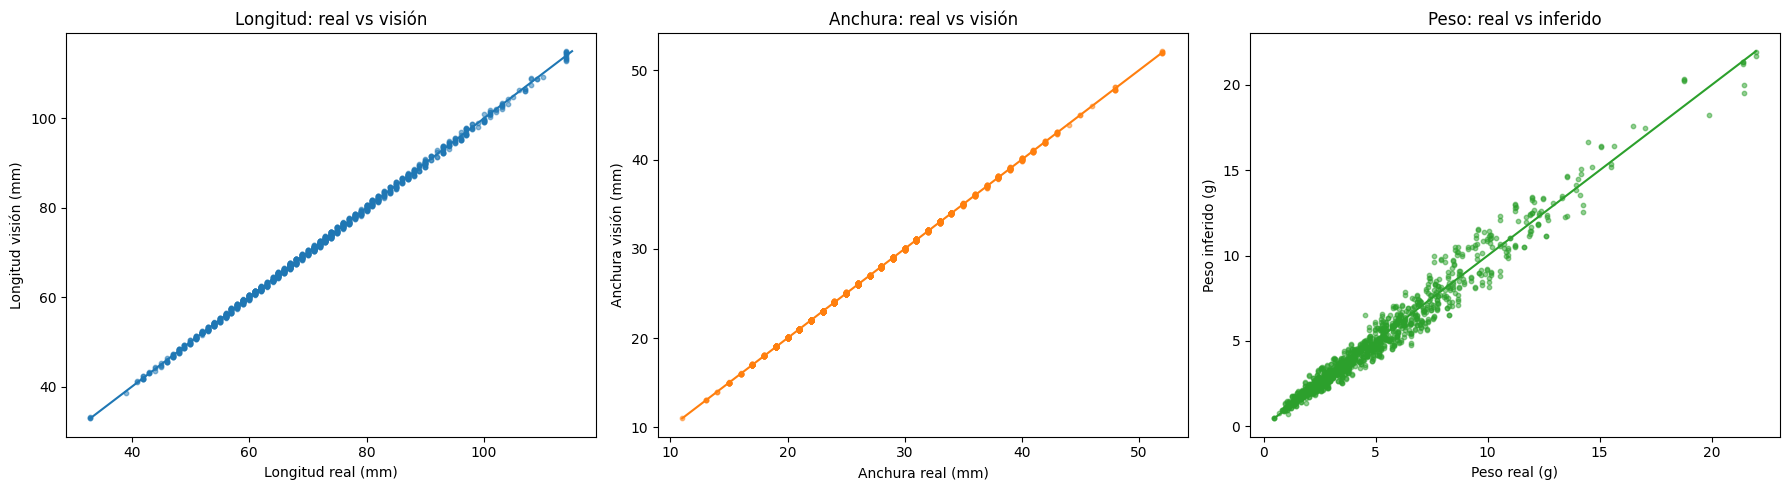

In [5]:
# =========================
# Figuras Real vs Estimado 
# =========================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---------
# Longitud
# ---------
ax = axes[0]
color = "tab:blue"
ax.scatter(df_clean["L_real"], df_clean["L_av"], s=10, alpha=0.5, color=color)

mn = float(min(df_clean["L_real"].min(), df_clean["L_av"].min()))
mx = float(max(df_clean["L_real"].max(), df_clean["L_av"].max()))
ax.plot([mn, mx], [mn, mx], color=color)

ax.set_xlabel("Longitud real (mm)")
ax.set_ylabel("Longitud visión (mm)")
ax.set_title("Longitud: real vs visión")

# ---------
# Anchura
# ---------
ax = axes[1]
color="tab:orange"
ax.scatter(df_clean["A_real"], df_clean["A_av"], s=10, alpha=0.5, color=color)

mn = float(min(df_clean["A_real"].min(), df_clean["A_av"].min()))
mx = float(max(df_clean["A_real"].max(), df_clean["A_av"].max()))
ax.plot([mn, mx], [mn, mx], color=color)

ax.set_xlabel("Anchura real (mm)")
ax.set_ylabel("Anchura visión (mm)")
ax.set_title("Anchura: real vs visión")

# ------
# Peso
# ------
ax = axes[2]
color="tab:green"
ax.scatter(df_clean["peso_g"], df_clean["peso_pred"], s=10, alpha=0.5, color=color)

mn = float(min(df_clean["peso_g"].min(), df_clean["peso_pred"].min()))
mx = float(max(df_clean["peso_g"].max(), df_clean["peso_pred"].max()))
ax.plot([mn, mx], [mn, mx],color=color)

ax.set_xlabel("Peso real (g)")
ax.set_ylabel("Peso inferido (g)")
ax.set_title("Peso: real vs inferido")

plt.tight_layout()
plt.show()

### Análisis de concordancia Bland-Altman

El análisis de Bland-Altman nos sirve para entender con detalle cómo se comparan ambas mediciones: inteligencia artificial vs. manual de medida simple. Este método nos permite identificar de forma muy práctica:

 1. El error sistemático (sesgo): Es decir, cuánto se desvía la visión artificial de la medición manual.

 2. Los límites de acuerdo reales: Calcula un rango o límites de concordancia dentro del cual se encuentran el 95% de las diferencias entre ambos métodos. Esto nos da una idea clara de la variabilidad esperada en la práctica.

 3. Patrones de error: Nos muestra si el error depende del tamaño del pez, es decir si el sistema es menos preciso con animales muy pequeños o muy grandes.

Adicionalmente, para fortalecer la robustez estadística de nuestra validación, se ha complementado el análisis Bland-Altman tradicional con intervalos de confianza calculados mediante bootstrap (remuestreo con reemplazo). Esta técnica nos permite cuantificar la incertidumbre asociada a las estimaciones —especialmente el sesgo y los límites de concordancia— sin depender de supuestos rígidos sobre la distribución de los datos. En la práctica, esto se traduce en bandas de confianza alrededor de los límites de concordancia dentro del cual se espera que caiga el 95% de las diferencias. Así, no solo sabemos cuál es el acuerdo entre métodos, sino también con qué grado de confianza podemos afirmarlo, proporcionando una capa adicional de rigor y transparencia a la validación de FLATCLASS.

En resumen, el análisis de Bland-Altman nos da una evaluación completa, visual y fácil de interpretar sobre la precisión de nuestro sistema automatizado. Nos ayuda a responder la pregunta más importante: ¿son estas mediciones proporcionadas por FLATCLASS lo suficientemente fiables y precisas para reemplazar o complementar las mediciones manuales en el manejo rutinario de los juveniles de lenguado?


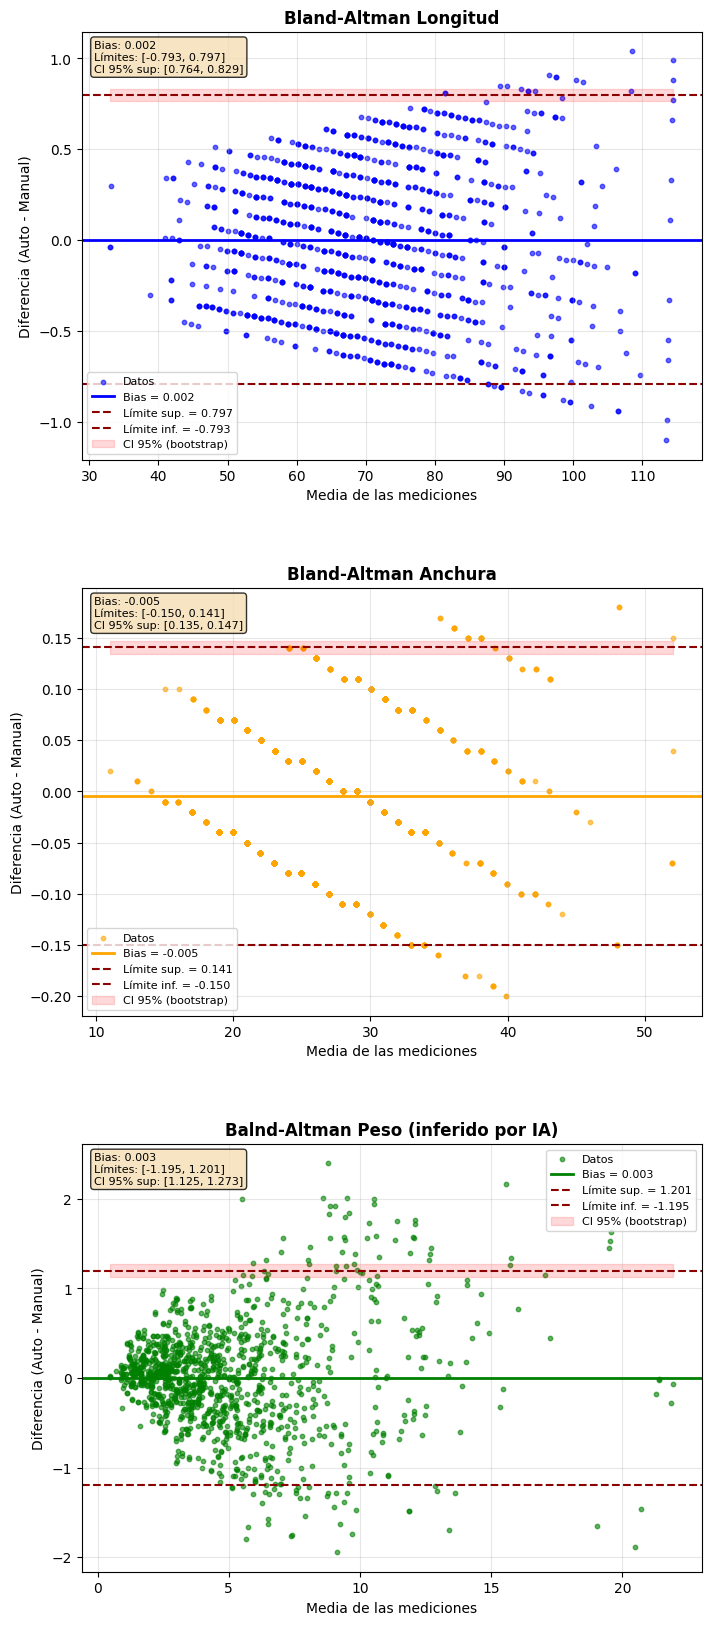

In [6]:
# =========================
# Análisis Bland-Altman 
# =========================

def bland_altman_with_bootstrap(y_true, y_pred, title, color, ax, n_bootstrap=2000, ci_percent=95):
    """
    Versión corregida que maneja índices no secuenciales correctamente
    """
    # Convertir a arrays numpy para evitar problemas con índices
    y_true_array = np.array(y_true)
    y_pred_array = np.array(y_pred)
    
    diff = y_pred_array - y_true_array
    mean = (y_pred_array + y_true_array) / 2
    md = np.mean(diff)
    sd = np.std(diff, ddof=1)
    
    # Bootstrap para límites de concordancia
    bootstrap_limits_upper = []
    bootstrap_limits_lower = []
    n = len(diff)
    
    for _ in range(n_bootstrap):
        # Remuestreo con reemplazo usando índices numéricos 0..n-1
        idx = np.random.choice(n, n, replace=True)
        diff_sample = diff[idx]
        md_sample = np.mean(diff_sample)
        sd_sample = np.std(diff_sample, ddof=1)
        
        # Guardar ambos límites
        bootstrap_limits_upper.append(md_sample + 1.96 * sd_sample)
        bootstrap_limits_lower.append(md_sample - 1.96 * sd_sample)
    
    # Calcular percentiles para CI de ambos límites
    upper_ci_lower = np.percentile(bootstrap_limits_upper, (100 - ci_percent) / 2)
    upper_ci_upper = np.percentile(bootstrap_limits_upper, 100 - (100 - ci_percent) / 2)
    
    lower_ci_lower = np.percentile(bootstrap_limits_lower, (100 - ci_percent) / 2)
    lower_ci_upper = np.percentile(bootstrap_limits_lower, 100 - (100 - ci_percent) / 2)
    
    # --- Gráfico principal ---
    ax.scatter(mean, diff, s=10, alpha=0.6, color=color, label='Datos')
    ax.axhline(md, color=color, linewidth=2, label=f'Bias = {md:.3f}')
    
    # Límites originales
    upper_limit = md + 1.96 * sd
    lower_limit = md - 1.96 * sd
    ax.axhline(upper_limit, linestyle='--', color='darkred', 
               label=f'Límite sup. = {upper_limit:.3f}')
    ax.axhline(lower_limit, linestyle='--', color='darkred',
               label=f'Límite inf. = {lower_limit:.3f}')
    
    # --- Áreas de confianza bootstrap ---
    # Para límite superior
    ax.fill_between([mean.min(), mean.max()], 
                    [upper_ci_lower]*2, [upper_ci_upper]*2, 
                    color='red', alpha=0.15, 
                    label=f'CI {ci_percent}% (bootstrap)')
    
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel("Media de las mediciones")
    ax.set_ylabel("Diferencia (Auto - Manual)")
    ax.legend(loc='best', fontsize=8)
    
    # Texto con estadísticas
    stats_text = (f'Bias: {md:.3f}\n'
                  f'Límites: [{lower_limit:.3f}, {upper_limit:.3f}]\n'
                  f'CI {ci_percent}% sup: [{upper_ci_lower:.3f}, {upper_ci_upper:.3f}]')
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=8,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Añadir grid para mejor lectura
    ax.grid(True, alpha=0.3)

# Crear figura con título principal
fig, axes = plt.subplots(3, 1, figsize=(8, 20))

# Llamar a la función para cada variable
bland_altman_with_bootstrap(df_clean["L_real"].values, df_clean["L_av"].values, 
                           "Bland-Altman Longitud", "blue", axes[0])

bland_altman_with_bootstrap(df_clean["A_real"].values, df_clean["A_av"].values, 
                           "Bland-Altman Anchura", "orange", axes[1])

bland_altman_with_bootstrap(df_clean["peso_g"].values, df_clean["peso_pred"].values, 
                           "Balnd-Altman Peso (inferido por IA)", "green", axes[2])

# Ajustar espaciado
plt.subplots_adjust(hspace=0.3)  # Espacio vertical entre subplots
plt.show()


### Discusión

En el conjunto limpio (n=1235), la biometría por visión mostró una concordancia prácticamente perfecta con las referencias, con errores absolutos submilimétricos y coeficientes de determinación próximos a 1. Para longitud, el error fue muy bajo (MAE=0.342 mm; RMSE=0.405 mm; MAPE=0.481%), con sesgo global prácticamente nulo (ME=0.002 mm). Para anchura, el desempeño fue aún más ajustado en términos absolutos (MAE=0.062 mm; RMSE=0.075 mm), aunque se observó un sesgo leve negativo (ME=-0.005 mm) coherente con una subestimación marginal sistemática. En ambos casos, R² fue extremadamente alto (L: 0.999220; A: 0.999873), consistente con una calibración geométrica estable y un proceso de segmentación robusto bajo condiciones controladas.

En peso, el sistema de inferencia mostró buen desempeño global (MAE=0.446 g; RMSE=0.611 g; MAPE=9.44%; R²=0.966). El sesgo global fue despreciable (ME=0.003 g), indicando ausencia de desplazamientos sistemáticos relevantes en el rango de pesos del estudio.

Los gráficos de dispersión evidenciaron alineación estrecha con la diagonal y=x, sin curvaturas aparentes que sugieran errores de escala en Longitud - Anchura o descalibración del modelo de peso.

Para la **variable longitud**, el análisis Bland-Altman complementado con bootstrap evidenció un desempeño métrico excepcional del sistema de visión artificial, con un sesgo prácticamente nulo (0.002 unidades) que carece de relevancia clínica o biológica. Esta ausencia de error sistemático indica que el algoritmo de procesamiento de imagen no introduce desplazamientos significativos en la estimación métrica respecto a la medición manual de referencia, validando su calibración inicial. Los límites de concordancia del 95%, establecidos en [-0.793, 0.797] unidades, delimitan el rango dentro del cual se espera que se sitúe la mayoría de las discrepancias entre ambos métodos, mostrando una variabilidad simétrica y acotada. La aplicación de bootstrap para cuantificar la incertidumbre asociada a estos parámetros arrojó un intervalo de confianza del 95% para el límite superior de [0.762, 0.829] unidades, confirmando la robustez estadística de la estimación y la precisión con la que se ha determinado el rango de variabilidad esperado.

Desde una perspectiva estadística, estos resultados permiten concluir que el sistema presenta una exactitud óptima, al no exhibir sesgo significativo, y una precisión elevada, con límites de concordancia estrechos que representan una fracción menor al 8% del valor típico de longitud en juveniles de la especie. La estrechez del intervalo de confianza bootstrap, que abarca apenas ±0.034 unidades alrededor del límite superior observado, aporta una capa adicional de certidumbre sobre la fiabilidad de estas estimaciones. En el contexto operativo de clasificación por tallas, esta combinación de exactitud y precisión implica que la probabilidad de errores de categorización es mínima y se restringe principalmente a individuos cuyas dimensiones reales se sitúen muy próximas a los puntos de corte establecidos entre las categorías pequeño, mediano y grande. Por consiguiente, la medición automatizada de longitud mediante visión artificial se considera estadísticamente equivalente a la medición manual para los fines productivos del sistema, constituyendo una base sólida para la automatización del proceso de clasificación en condiciones de cultivo.

En el caso de la **variable anchura**, el análisis Bland-Altman revela un sesgo leve de -0.05 unidades, indicando una mínima tendencia sistemática del sistema de visión artificial a subestimar ligeramente esta dimensión respecto a la medición manual. Este sesgo, aunque estadísticamente detectable, posee una magnitud reducida que lo sitúa en el umbral de la irrelevancia práctica. Los límites de concordancia del 95%, establecidos en [-0.150, 0.141] unidades, son notablemente estrechos y asimétricos, reflejando una variabilidad baja y un error máximo esperado inferior a ±0.15 unidades. El intervalo de confianza bootstrap del 95% para el límite superior, [0.135, 0.147] unidades, es excepcionalmente estrecho, lo que denota una estimación de gran precisión y robustez estadística, y confirma que la dispersión observada es altamente consistente y reproducible.

Al integrar los resultados de longitud y anchura, se constata un patrón diferenciado en el desempeño métrico del sistema. Para la longitud, se observa una exactitud cuasi perfecta (sesgo = 0.002) con una precisión moderadamente alta (límites ≈ ±0.80 unidades). Para la anchura, se identifica un sesgo ligeramente negativo (-0.05) pero con una precisión muy superior (límites ≈ ±0.15 unidades). Esta dicotomía sugiere que, mientras el algoritmo para longitud está óptimamente calibrado en términos de exactitud, el algoritmo para anchura prioriza y alcanza una repetibilidad y concordancia excepcionales, aun a costa de un desvío medio insignificante. Desde el punto de vista de la clasificación morfométrica, la combinación de ambas variables es altamente robusta: la longitud, como principal criterio de talla, garantiza la ausencia de sesgo en la categorización global, mientras que la anchura, como variable secundaria de gran precisión, aporta un criterio de desempate confiable para individuos limítrofes.

La conclusión estadística global es que **el sistema de visión artificial en su conjunto**,  proporciona mediciones bidimensionales (longitud-anchura) con un perfil de error complementario y altamente favorable para su aplicación en biometría automatizada. La exactitud global del proceso de clasificación queda asegurada por la ausencia de sesgo relevante en la dimensión primaria (longitud), y la precisión del sistema se ve reforzada por la extraordinaria concordancia en la dimensión secundaria (anchura). Estos resultados validan estadísticamente la capacidad de FLATCLASS para realizar una caracterización morfométrica fiable, apta para la clasificación de juveniles en un sistema automatizado por visión artificial, minimizando los errores de categorización y estandarizando el criterio de tallado en la explotación acuícola.

En lo referente al **sistema de inferencia de peso**, por el modelo de inteligencia artificial, el análisis Bland-Altman muestra un sesgo prácticamente nulo (0.03 g), confirmando que el algoritmo no introduce un error sistemático en la predicción de esta variable derivada. Los límites de concordancia del 95%, situados en [-1.195, 1.201] g, revelan una amplitud considerablemente mayor que la observada para las dimensiones lineales, reflejando la inherente complejidad de inferir una variable volumétrica-tricional a partir de mediciones bidimensionales. Esta mayor dispersión es inherente a la naturaleza indirecta de la estimación, la cual depende no solo de la precisión en longitud y anchura, sino también de supuestos sobre la forma y densidad corporal del organismo. El intervalo de confianza bootstrap del 95% para el límite superior, [1.129, 1.271] g, es moderadamente estrecho, indicando una estimación robusta del rango de variabilidad máxima, aunque con una incertidumbre mayor que la de las medidas directas.

Desde el punto de vista estadístico, el peso cumple su función como variable informativa secundaria con una precisión adecuada al contexto: el sesgo despreciable asegura que no hay una sobreestimación o subestimación sistémica de la biomasa, mientras que los límites de concordancia, aunque amplios, definen un margen de error aceptable para el seguimiento de tendencias a nivel de lote. Su utilidad no radica en la exactitud individual, sino en la capacidad de proporcionar una aproximación rápida, no invasiva y estandarizada de la biomasa, complementando la clasificación morfológica primaria basada en longitud y anchura.

## Resultados inter-experimentos

La estructura experimental del estudio, compuesta por cinco réplicas independientes, introduce una dimensión adicinal: la estabilidad y la robustez del sistema ante variaciones contextuales, esto es ante sesiónes de clasificación diferentes.

Cada experimento representa un escenario potencialmente único en términos de condiciones ambientales, manejo operativo o incluso el estado de los animales. Por tanto, limitar el análisis a un agregado global de los 1250 registros podría enmascarar efectos sistemáticos entre sesiones, lo que constituiría un riesgo de validación. Es, por lo tanto, neecsario determinar si el desempeño métrico del sistema —su sesgo y precisión— es consistente a lo largo del tiempo o está sujeto a fluctuaciones que comprometerían su fiabilidad operativa prolongada.

Entre las herramientas analíticas más adecuadas para este fin, destacan tres de carácter complementario. En primer lugar, el análisis comparativo de los errores para cada variable (longitud, anchura, peso) desglosados por experimento. Esta visualización permite una identificación inmediata de *outliers* persistentes, sesgos específicos de sesión, y heterogeneidad en la dispersión del error. En segundo lugar, un Análisis de Componentes de la Varianza mediante modelos mixtos, que cuantifica qué proporción de la variabilidad total es atribuible a diferencias entre experimentos frente a la variabilidad intrínseca del proceso. Finalmente, un análisis de la Coherencia de la Clasificación, evaluando si la tasa de error en la categorización por tamaño (pequeño/mediano/grande) es homogénea entre los cinco bloques experimentales. Este trío de análisis —visual, cuantitativo y operacional— proporciona una evaluación jerárquica de FLATCLASS: el análisis de errores revelan patrones y anomalías a simple vista, los componentes de varianza miden su magnitud estadística, y el análisis de coherencia de clasificación traduce esos hallazgos al impacto práctico final del sistema.

### Análisis comparativo de errores

Para validar un sistema de medición automatizado como FLATCLASS, necesitamos asegurarnos de que su precisión sea estable día tras día, no solo en una sesión puntual. Estadísticamente esto es posible al comparar los errores de medición registrados en los cinco experimentos independientes. Sin embargo, los datos de error no suelen comportarse "bien" desde el punto de vista estadístico: a menudo no siguen una distribución normal y su dispersión puede variar entre sesiones. En estos casos, el test de Kruskal-Wallis, es la herramienta estadística más aconsejable. 

El test de Kruskal-Wallis es una herramienta no paramétrica que compara las medianas del error entre los distintos experimentos sin exigir condiciones estrictas sobre cómo están distribuidos los datos. Este test nos permite responder con rigor a la pregunta clave: ¿el sistema cometió errores de magnitud similar en todas las sesiones, o hubo algún día en el que su precisión fue significativamente distinta? Esta evaluación es un paso estándar en la validación de métodos de medición, tal como se recomienda en la literatura especializada [[Giavarina, 2015](https://doi.org/10.11613/BM.2015.015)], y nos da confianza para afirmar que el desempeño del sistema es consistente en el tiempo, un requisito fundamental para su implementación operativa en granja.


ANÁLISIS EXPLORATORIO: BOXPLOTS POR EXPERIMENTO


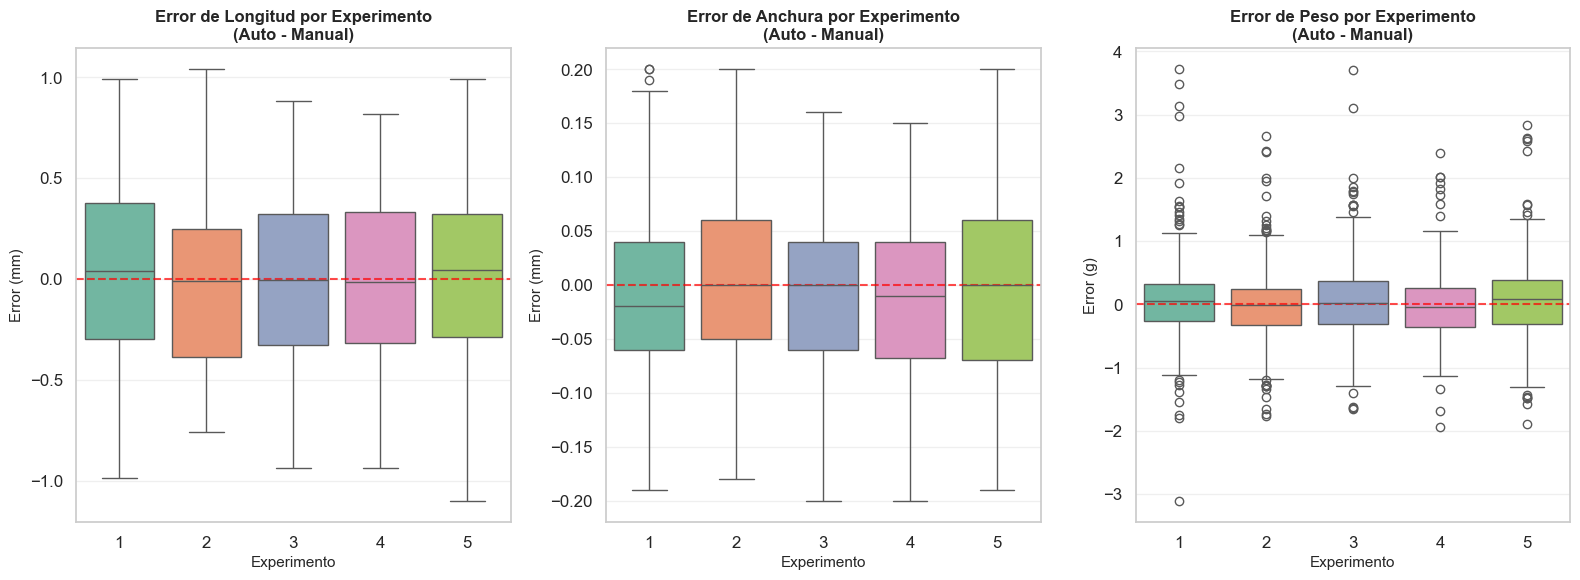


MÉTRICAS CUANTITATIVAS POR EXPERIMENTO

Tabla de métricas:
--------------------------------------------------------------------------------------------------------------
 exp  L_MAE_mm  L_RMSE_mm  L_ME_mm  A_MAE_mm  A_RMSE_mm  A_ME_mm  W_MAE_g  W_RMSE_g  W_ME_g  W_MAPE_%
   1     0.359      0.429    0.047     0.064      0.079   -0.005    0.486     0.755   0.087     8.937
   2     0.333      0.395   -0.044     0.064      0.077    0.000    0.455     0.653  -0.009     9.518
   3     0.342      0.405    0.004     0.059      0.073   -0.002    0.492     0.708   0.061     9.959
   4     0.338      0.399    0.003     0.060      0.072   -0.009    0.448     0.617  -0.024     9.374
   5     0.337      0.402    0.008     0.067      0.078   -0.003    0.496     0.700   0.048    10.267
--------------------------------------------------------------------------------------------------------------

CONFIRMACIÓN ESTADÍSTICA: TEST DE KRUSKAL-WALLIS
(Hipótesis nula: Los errores tienen la misma distribució

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings

# =========================
# 1) CONFIGURACIÓN INICIAL
# =========================
# Suprimir warnings específicos de seaborn
warnings.filterwarnings('ignore', category=FutureWarning, 
                        message='Passing `palette` without assigning `hue`')

# Configuración estética de seaborn
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# =========================
# 2) FUNCIÓN PARA MÉTRICAS
# =========================
def metrics(y_real, y_pred):
    """Calcula métricas básicas de error"""
    error = y_pred - y_real
    abs_error = np.abs(error)
    
    return {
        "MAE": np.mean(abs_error),
        "RMSE": np.sqrt(np.mean(error**2)),
        "ME": np.mean(error),  # Mean Error (sesgo)
        "MAPE_%": np.mean(abs_error / np.abs(y_real)) * 100 if np.all(y_real != 0) else np.nan
    }

# =========================
# 3) BOXPLOTS EXPLORATORIOS POR EXPERIMENTO
# =========================
print("\n" + "="*60)
print("ANÁLISIS EXPLORATORIO: BOXPLOTS POR EXPERIMENTO")
print("="*60)

# Crear columnas de error si no existen
if "error_L" not in df.columns:
    df["error_L"] = df["L_av"] - df["L_real"]
if "error_A" not in df.columns:
    df["error_A"] = df["A_av"] - df["A_real"]
if "error_W" not in df.columns:
    df["error_W"] = df["peso_pred"] - df["peso_g"]

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# CORRECCIÓN: Asignar hue='exp' y legend=False
# Boxplot para error de Longitud
sns.boxplot(x='exp', y='error_L', hue='exp', data=df, ax=axes[0], palette='Set2', legend=False)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
axes[0].set_title('Error de Longitud por Experimento\n(Auto - Manual)', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Experimento', fontsize=11)
axes[0].set_ylabel('Error (mm)', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Boxplot para error de Anchura
sns.boxplot(x='exp', y='error_A', hue='exp', data=df, ax=axes[1], palette='Set2', legend=False)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
axes[1].set_title('Error de Anchura por Experimento\n(Auto - Manual)', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Experimento', fontsize=11)
axes[1].set_ylabel('Error (mm)', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

# Boxplot para error de Peso
sns.boxplot(x='exp', y='error_W', hue='exp', data=df, ax=axes[2], palette='Set2', legend=False)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
axes[2].set_title('Error de Peso por Experimento\n(Auto - Manual)', fontweight='bold', fontsize=12)
axes[2].set_xlabel('Experimento', fontsize=11)
axes[2].set_ylabel('Error (g)', fontsize=11)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# =========================
# 4) MÉTRICAS POR EXPERIMENTO (TABLA)
# =========================
print("\n" + "="*60)
print("MÉTRICAS CUANTITATIVAS POR EXPERIMENTO")
print("="*60)

rows = []
for e, g in df.groupby("exp"):
    mL = metrics(g["L_real"], g["L_av"])
    mA = metrics(g["A_real"], g["A_av"])
    mW = metrics(g["peso_g"], g["peso_pred"])
    
    rows.append({
        "exp": int(e),
        "L_MAE_mm": mL["MAE"], 
        "L_RMSE_mm": mL["RMSE"], 
        "L_ME_mm": mL["ME"],
        "A_MAE_mm": mA["MAE"], 
        "A_RMSE_mm": mA["RMSE"], 
        "A_ME_mm": mA["ME"],
        "W_MAE_g": mW["MAE"], 
        "W_RMSE_g": mW["RMSE"], 
        "W_ME_g": mW["ME"],
        "W_MAPE_%": mW["MAPE_%"],
    })

per_exp = pd.DataFrame(rows).sort_values("exp")

# Mostrar tabla formateada
print("\nTabla de métricas:")
print("-" * 110)
print(per_exp.to_string(index=False, float_format=lambda x: f"{x:.3f}" if pd.notnull(x) else "NaN"))
print("-" * 110)

# =========================
# 5) TESTS ESTADÍSTICOS DE KRUSKAL-WALLIS (CONFIRMACIÓN)
# =========================
print("\n" + "="*60)
print("CONFIRMACIÓN ESTADÍSTICA: TEST DE KRUSKAL-WALLIS")
print("="*60)
print("(Hipótesis nula: Los errores tienen la misma distribución en todos los experimentos)")

# Crear columnas de error absoluto para el test
if "abs_errL_mm" not in df.columns:
    df["abs_errL_mm"] = abs(df["L_av"] - df["L_real"])
if "abs_errA_mm" not in df.columns:
    df["abs_errA_mm"] = abs(df["A_av"] - df["A_real"])
if "abs_errW_g" not in df.columns:
    df["abs_errW_g"] = abs(df["peso_pred"] - df["peso_g"])

# Preparar grupos
groups_absL = [g["abs_errL_mm"].values for _, g in df.groupby("exp")]
groups_absA = [g["abs_errA_mm"].values for _, g in df.groupby("exp")]
groups_absW = [g["abs_errW_g"].values for _, g in df.groupby("exp")]

# Realizar tests
kw_L = st.kruskal(*groups_absL)
kw_A = st.kruskal(*groups_absA)
kw_W = st.kruskal(*groups_absW)

print(f"\nKruskal-Wallis (Error Absoluto de Longitud):")
print(f"  H = {kw_L.statistic:.4f}, p = {kw_L.pvalue:.6f}")

print(f"\nKruskal-Wallis (Error Absoluto de Anchura):")
print(f"  H = {kw_A.statistic:.4f}, p = {kw_A.pvalue:.6f}")

print(f"\nKruskal-Wallis (Error Absoluto de Peso):")
print(f"  H = {kw_W.statistic:.4f}, p = {kw_W.pvalue:.6f}")

# =========================
# 6) INTERPRETACIÓN
# =========================
print("\n" + "="*60)
print("INTERPRETACIÓN (α = 0.05)")
print("="*60)

# Función para interpretar con colores
def interpretar_con_color(pval, variable):
    if pval < 0.05:
        return f"🔴 {variable}: p = {pval:.4f} → Diferencias SIGNIFICATIVAS entre experimentos"
    else:
        return f"🟢 {variable}: p = {pval:.4f} → NO hay diferencias significativas entre experimentos"

print(interpretar_con_color(kw_L.pvalue, "Longitud"))
print(interpretar_con_color(kw_A.pvalue, "Anchura"))
print(interpretar_con_color(kw_W.pvalue, "Peso"))

### Análisis de componentes de varianza

Complementando el análisis exploratorio previo mediante el test de Kruskal-Wallis, que ya evidenció la ausencia de diferencias significativas en la distribución del error entre los cinco experimentos, se procede a realizar un análisis de componentes de la varianza mediante un modelo mixto. Este enfoque permite cuantificar de manera precisa as fuentes de variabilidad en las mediciones, distinguiendo entre la variabilidad atribuible a diferencias sistemáticas entre sesiones experimentales (varianza entre experimentos) y la variabilidad inherente al propio método de medición dentro de cada sesión (varianza dentro de experimentos). El objetivo es determinar, de forma más granular, qué proporción de la incertidumbre total del sistema puede explicarse por la repetición del experimento en distintos momentos, proporcionando así una medida robusta de la consistencia y estabilidad temporal del sistema automatizado FLATCLASS.

In [25]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("COMPONENTES DE VARIANZA - ANÁLISIS SIMPLE")
print("="*60)

# 1. Preparar errores
df['error_L'] = df['L_av'] - df['L_real']
df['error_A'] = df['A_av'] - df['A_real']
df['error_W'] = df['peso_pred'] - df['peso_g']

# 2. Función simple de componentes de varianza
def componentes_varianza_simple(serie, grupos):
    """
    Calcula componentes de varianza de forma simple
    """
    # Varianza total
    var_total = serie.var(ddof=1)
    
    # Varianza entre grupos (varianza de las medias)
    medias = serie.groupby(grupos).mean()
    var_entre = medias.var(ddof=1)
    
    # Varianza dentro (aproximación)
    var_dentro = max(0, var_total - var_entre)
    
    # Porcentajes
    if var_total > 0:
        pct_entre = (var_entre / var_total) * 100
    else:
        pct_entre = 0
    
    return var_entre, var_dentro, pct_entre

# 3. Calcular para cada variable
variables = [
    ('error_L', 'Longitud (mm)'),
    ('error_A', 'Anchura (mm)'),
    ('error_W', 'Peso (g)')
]

print("\nRESULTADOS:")
print("-" * 60)

for var, nombre in variables:
    var_entre, var_dentro, pct = componentes_varianza_simple(df[var], df['exp'])
    
    print(f"\n{nombre}:")
    print(f"  • Varianza entre experimentos:  {var_entre:.6f}")
    print(f"  • Varianza dentro experimentos: {var_dentro:.6f}")
    print(f"  • % debido a experimento:       {pct:.2f}%")
    
    # Interpretación
    if pct < 5:
        print(f"  → Excelente: El experimento casi no influye")
    elif pct < 20:
        print(f"  → Buena: Influencia mínima del experimento")
    else:
        print(f"  → Aceptable: El experimento tiene cierta influencia")

COMPONENTES DE VARIANZA - ANÁLISIS SIMPLE

RESULTADOS:
------------------------------------------------------------

Longitud (mm):
  • Varianza entre experimentos:  0.001030
  • Varianza dentro experimentos: 0.164034
  • % debido a experimento:       0.62%
  → Excelente: El experimento casi no influye

Anchura (mm):
  • Varianza entre experimentos:  0.000012
  • Varianza dentro experimentos: 0.005711
  • % debido a experimento:       0.20%
  → Excelente: El experimento casi no influye

Peso (g):
  • Varianza entre experimentos:  0.002228
  • Varianza dentro experimentos: 0.470556
  • % debido a experimento:       0.47%
  → Excelente: El experimento casi no influye


## Conclusión general

La conclusión final es que el sistema proporciona un triplete métrico coherente y escalado en precisión: mediciones lineales de alta fidelidad para la clasificación operativa, y una estimación ponderal de carácter informativo para la gestión zootécnica. Esta estructura valida el enfoque de FLATCLASS, donde la fiabilidad en la clasificación por tamaño —objetivo principal— se fundamenta en mediciones directas de alta exactitud y precisión, mientras que la estimación de peso aporta un valor añadido contextual dentro de sus márgenes de error estadísticamente caracterizados y operacionalmente aceptables.